<a href="https://colab.research.google.com/github/madhurapanvelkar20/Netflix-show-Clustering-using-K-Means/blob/main/Netflix_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
df = pd.read_csv('netflix_titles.csv')

In [ ]:
print("Dataset Shape: ",df.shape)
print("\nColumn Names: ")
print(df.columns.tolist())
print("\nFirst 5 rows: ")
print(df.head())

print("\nDataset Info: ")
print(df.info())

print("\nMissing Values: ")
print(df.isnull().sum())

Dataset Shape:  (8807, 12)

Column Names: 
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

First 5 rows: 
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

 

In [ ]:
df_processed = df.copy()

df_processed['director'] = df_processed['director'].fillna('Unknown Director')
df_processed['cast'] = df_processed['cast'].fillna('Unknown Cast')
df_processed['date_added'] = df_processed['date_added'].fillna('Unknown')
df_processed['description'] = df_processed['description'].fillna('No description available')

most_common_country = df_processed['country'].mode()[0] if not df_processed['country'].mode().empty else 'United States'
df_processed['country'] = df_processed['country'].fillna(most_common_country)

most_common_rating = df_processed['rating'].mode()[0] if not df_processed['rating'].mode().empty else 'TV-MA'
df_processed['rating'] = df_processed['rating'].fillna(most_common_rating)

def fill_missing_duration(row):
  if pd.isna(row['duration']):
    if row['type'] == 'Movie':
      return '90 min'
    else:
      return '1 Season'
  return row['duration']

df_processed['duration'] = df_processed.apply(fill_missing_duration, axis=1)

print(f"\nDataset shape after cleaning: {df_processed.shape}")
print("\nMissing values after cleaning:")
print(df_processed.isnull().sum())

clustering_columns = ['type','rating','duration','country','release_year']
missing_in_clustering = df_processed[clustering_columns].isnull().sum()
print(f"\nMissing values in clustering features:")
print(missing_in_clustering)

if missing_in_clustering.sum() > 0:
    print("WARNING: Still have missing values in clustering features!")
else:
    print("All clustering features are clean!")


Dataset shape after cleaning: (8807, 12)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Missing values in clustering features:
type            0
rating          0
duration        0
country         0
release_year    0
dtype: int64
All clustering features are clean!


In [ ]:
print("Available columns in dataset:")
print(df_processed.columns.tolist())

def extract_duration_minutes(duration_str):
    """Convert duration string to minutes"""
    if pd.isna(duration_str):
        return 0

    duration_str = str(duration_str).lower()

    if 'season' in duration_str:
        seasons = int(duration_str.split()[0])
        return seasons * 600

    elif 'min' in duration_str:
        return int(duration_str.split()[0])

    else:
        return 90

# Apply duration extraction
print("Creating 'duration_minutes' column...")
df_processed['duration_minutes'] = df_processed['duration'].apply(extract_duration_minutes)
print(f"Sample duration values: {df_processed['duration_minutes'].head().tolist()}")

# 2. CREATE CONTENT_AGE COLUMN
print("Creating 'content_age' column...")

# First ensure release_year is numeric
df_processed['release_year'] = pd.to_numeric(df_processed['release_year'], errors='coerce')
df_processed['release_year'] = df_processed['release_year'].fillna(df_processed['release_year'].median())

# Create age of content feature
current_year = 2025
df_processed['content_age'] = current_year - df_processed['release_year']
print(f"Sample content_age values: {df_processed['content_age'].head().tolist()}")

# 3. CREATE PRIMARY_COUNTRY COLUMN (already done, but keeping for completeness)
if 'primary_country' not in df_processed.columns:
    print("\n'primary_country' column not found. Creating it now...")

    # Extract country (take first country if multiple)
    df_processed['primary_country'] = df_processed['country'].apply(
        lambda x: x.split(',')[0].strip() if pd.notna(x) and x != 'Unknown' else 'Unknown'
    )

    print("'primary_country' column created successfully!")
    print(f"Sample values: {df_processed['primary_country'].head().tolist()}")
else:
    print("'primary_country' column already exists!")

# Verify all required columns now exist
required_columns = ['duration_minutes', 'content_age', 'primary_country']
print(f"\nChecking required columns:")
for col in required_columns:
    if col in df_processed.columns:
        print(f"{col}: exists")
    else:
        print(f"{col}: missing")

print(f"\nUnique countries: {df_processed['primary_country'].nunique()}")
print(f"Most common countries: {df_processed['primary_country'].value_counts().head()}")

label_encoders = {}

categorical_features = ['type','rating','primary_country']
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_processed[f'{feature}_encoded'] = label_encoders[feature].fit_transform(df_processed[feature])

clustering_features = [
    'type_encoded',
    'rating_encoded',
    'duration_minutes',
    'content_age',
    'primary_country_encoded'
]

# Verify all clustering features exist before creating matrix
print(f"\nChecking clustering features:")
missing_features = []
for feature in clustering_features:
    if feature in df_processed.columns:
        print(f"{feature}: exists")
    else:
        print(f"{feature}: missing")
        missing_features.append(feature)

if missing_features:
    print(f"\nERROR: Missing features: {missing_features}")
    print("Please check the feature engineering steps above.")
else:
    print("\nAll clustering features are ready!")

    X = df_processed[clustering_features].copy()

    print("\nFeatures selected for clustering: ")
    for i, feature in enumerate(clustering_features):
        print(f"{i+1}. {feature}")

    print(f"\nFeature matrix shape: {X.shape}")
    print("\nFeature matrix sample:")
    print(X.head())

    print(f"\nMissing values in feature matrix: {X.isnull().sum().sum()}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"\nScaled feature matrix shape: {X_scaled.shape}")
    print("Feature preparation complete!")

Available columns in dataset:
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
Creating 'duration_minutes' column...
Sample duration values: [90, 1200, 600, 600, 1200]
Creating 'content_age' column...
Sample content_age values: [5, 4, 4, 4, 4]

'primary_country' column not found. Creating it now...
'primary_country' column created successfully!
Sample values: ['United States', 'South Africa', 'United States', 'United States', 'India']

Checking required columns:
duration_minutes: exists
content_age: exists
primary_country: exists

Unique countries: 86
Most common countries: primary_country
United States     4042
India             1008
United Kingdom     628
Canada             271
Japan              259
Name: count, dtype: int64

Checking clustering features:
type_encoded: exists
rating_encoded: exists
duration_minutes: exists
content_age: exists
primary_country_encoded: exists

All clustering fea


Calculating optimal number of clusters...


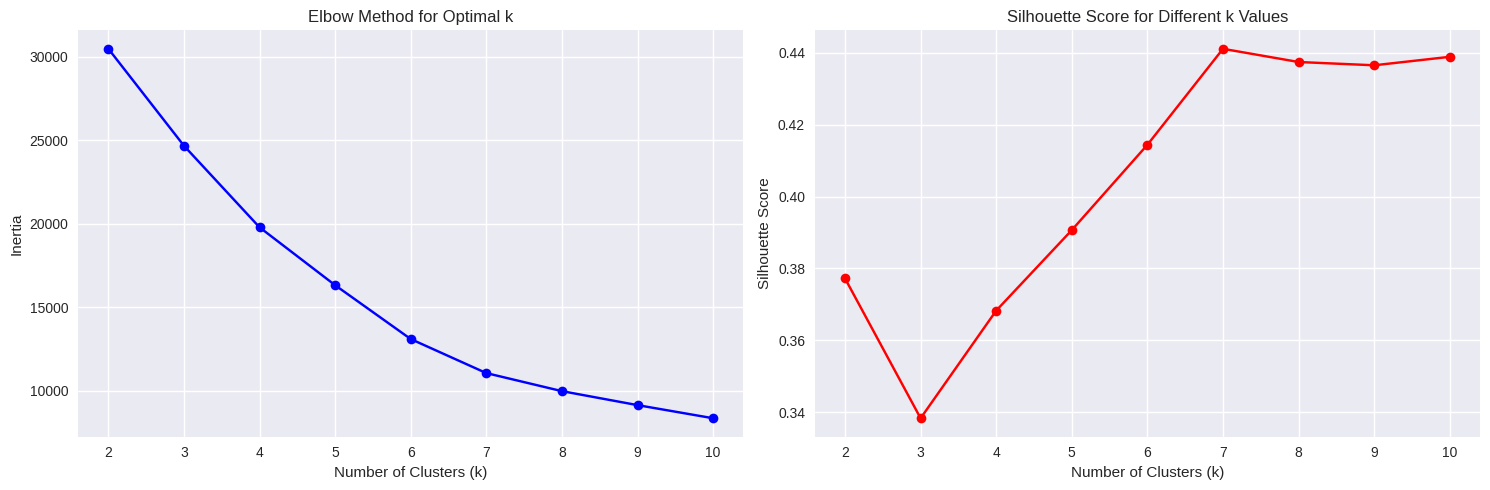

Optimal number of clusters based on silhouette score: 7


In [ ]:
print("\nCalculating optimal number of clusters...")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_scaled)
  inertias.append(kmeans.inertia_)

  cluster_labels = kmeans.labels_
  silhouette_avg = silhouette_score(X_scaled, cluster_labels)
  silhouette_scores.append(silhouette_avg)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k Values')
ax2.grid(True)

plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

In [ ]:
k = optimal_k

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_processed['cluster'] = cluster_labels

print(f"\nClustering completed with {k} clusters!")
print("\nCluster distribution:")
cluster_counts = df_processed['cluster'].value_counts().sort_index()
print(cluster_counts)


Clustering completed with 7 clusters!

Cluster distribution:
cluster
0    1673
1    1761
2    1835
3     246
4     418
5     739
6    2135
Name: count, dtype: int64


In [ ]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=clustering_features)

print(f"\n{'='*60}")
print("CLUSTER ANALYSIS")
print(f"{'='*60}")

for cluster_id in range(k):
    cluster_data = df_processed[df_processed['cluster'] == cluster_id]

    print(f"\nCLUSTER {cluster_id}:")
    print(f"Number of titles: {len(cluster_data)}")

    # Most common type
    common_type = cluster_data['type'].mode().iloc[0] if not cluster_data['type'].empty else 'Unknown'
    print(f"Most common type: {common_type}")

    # Most common rating
    common_rating = cluster_data['rating'].mode().iloc[0] if not cluster_data['rating'].empty else 'Unknown'
    print(f"Most common rating: {common_rating}")

    # Most common country
    common_country = cluster_data['primary_country'].mode().iloc[0] if not cluster_data['primary_country'].empty else 'Unknown'
    print(f"Most common country: {common_country}")

    # Average duration
    avg_duration = cluster_data['duration_minutes'].mean()
    print(f"Average duration: {avg_duration:.0f} minutes")

    # Average content age
    avg_age = cluster_data['content_age'].mean()
    print(f"Average content age: {avg_age:.1f} years")

    # Sample titles
    print(f"\nSample titles in this cluster:")
    sample_titles = cluster_data[['title', 'type', 'rating', 'duration', 'primary_country']].head(3)
    for idx, row in sample_titles.iterrows():
        print(f"  • {row['title']} ({row['type']}, {row['rating']}, {row['duration']}, {row['primary_country']})")


CLUSTER ANALYSIS

CLUSTER 0:
Number of titles: 1673
Most common type: TV Show
Most common rating: TV-MA
Most common country: United States
Average duration: 800 minutes
Average content age: 7.9 years

Sample titles in this cluster:
  • Blood & Water (TV Show, TV-MA, 2 Seasons, South Africa)
  • Ganglands (TV Show, TV-MA, 1 Season, United States)
  • Jailbirds New Orleans (TV Show, TV-MA, 1 Season, United States)

CLUSTER 1:
Number of titles: 1761
Most common type: Movie
Most common rating: R
Most common country: United States
Average duration: 102 minutes
Average content age: 11.4 years

Sample titles in this cluster:
  • Dick Johnson Is Dead (Movie, PG-13, 90 min, United States)
  • My Little Pony: A New Generation (Movie, PG, 91 min, United States)
  • The Starling (Movie, PG-13, 104 min, United States)

CLUSTER 2:
Number of titles: 1835
Most common type: Movie
Most common rating: TV-MA
Most common country: United States
Average duration: 85 minutes
Average content age: 8.1 years

S

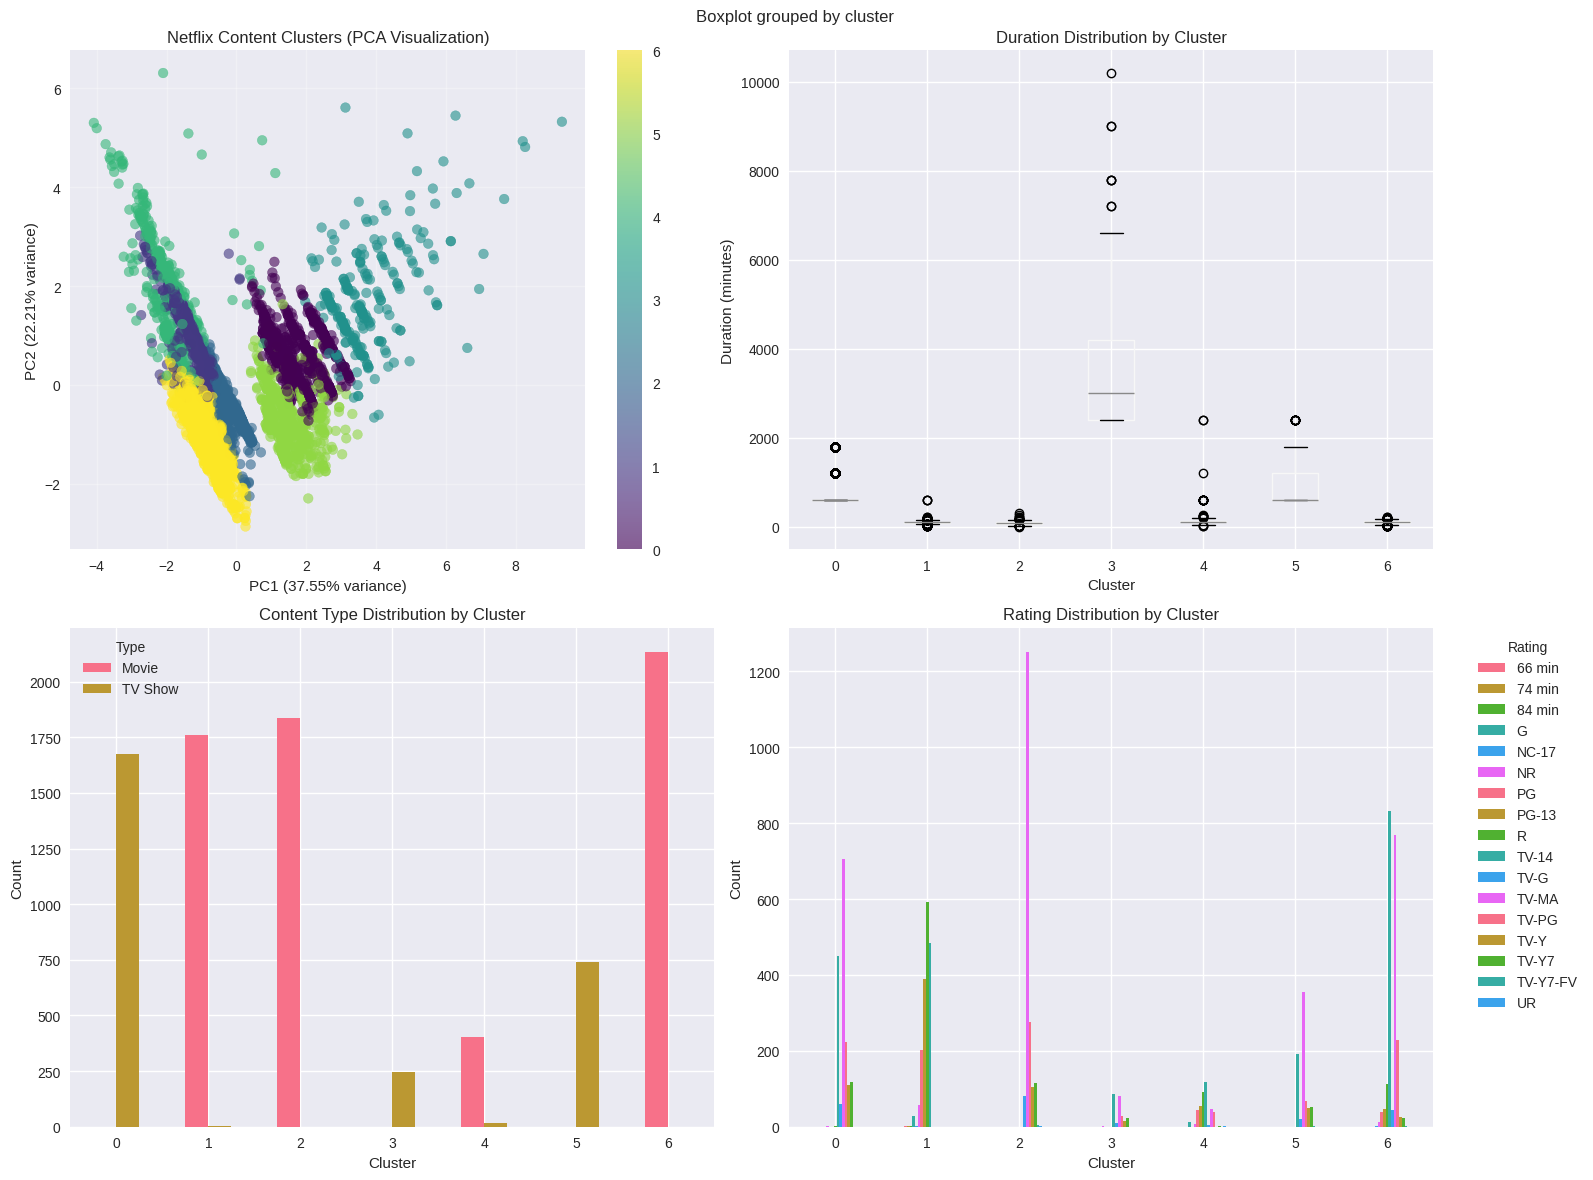

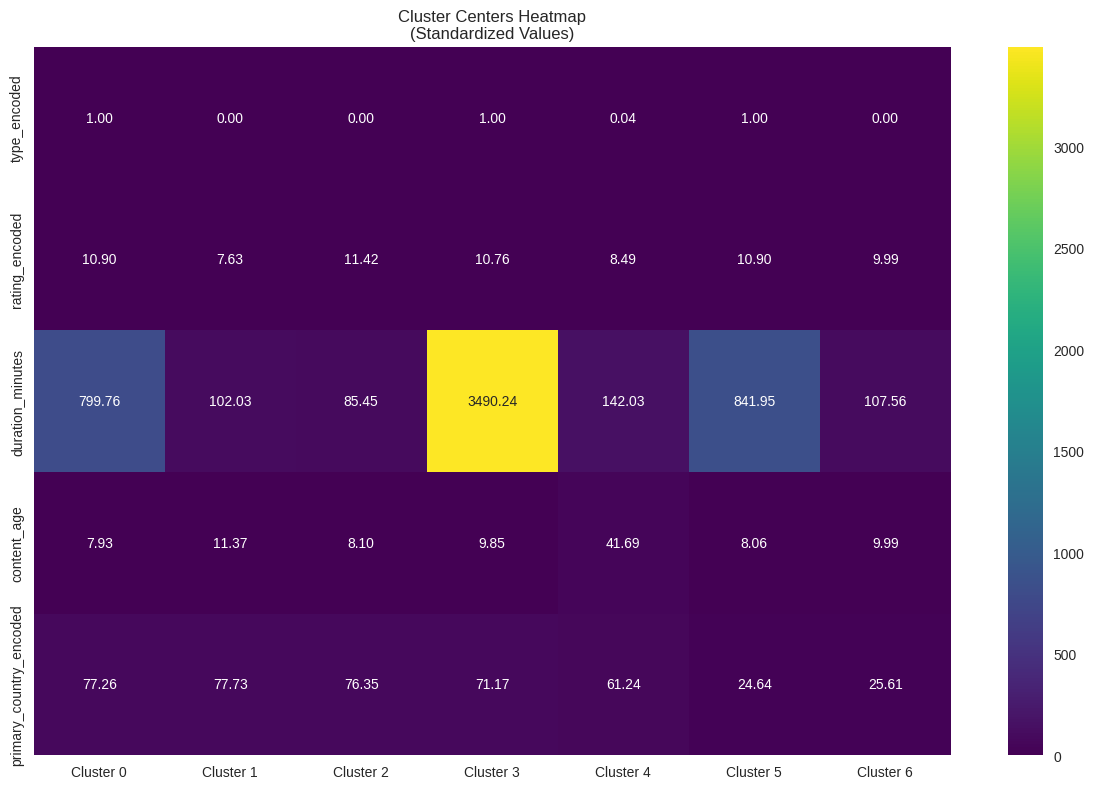

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA Scatter Plot
scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0,0].set_title('Netflix Content Clusters (PCA Visualization)')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0,0])

# 2. Duration distribution by cluster
df_processed.boxplot(column='duration_minutes', by='cluster', ax=axes[0,1])
axes[0,1].set_title('Duration Distribution by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Duration (minutes)')

# 3. Type distribution by cluster
type_cluster = pd.crosstab(df_processed['cluster'], df_processed['type'])
type_cluster.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Content Type Distribution by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title='Type')
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Rating distribution by cluster
rating_cluster = pd.crosstab(df_processed['cluster'], df_processed['rating'])
rating_cluster.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Rating Distribution by Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Count')
axes[1,1].legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Create heatmap of cluster characteristics
plt.figure(figsize=(12, 8))
heatmap_data = centers_df.T
sns.heatmap(heatmap_data,
           annot=True,
           cmap='viridis',
           fmt='.2f',
           xticklabels=[f'Cluster {i}' for i in range(k)],
           yticklabels=clustering_features)
plt.title('Cluster Centers Heatmap\n(Standardized Values)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calculate clustering metrics
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
calinski_score = calinski_harabasz_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

print(f"\n{'='*40}")
print("CLUSTERING EVALUATION METRICS")
print(f"{'='*40}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_score:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
print(f"\nInterpretation:")
print(f"• Silhouette Score: Higher is better (range: -1 to 1)")
print(f"• Calinski-Harabasz: Higher is better")
print(f"• Davies-Bouldin: Lower is better")


CLUSTERING EVALUATION METRICS
Silhouette Score: 0.4411
Calinski-Harabasz Score: 4371.4293
Davies-Bouldin Score: 0.8431

Interpretation:
• Silhouette Score: Higher is better (range: -1 to 1)
• Calinski-Harabasz: Higher is better
• Davies-Bouldin: Lower is better


In [ ]:
# Save clustered dataset
output_file = 'netflix_clustered_results.csv'
df_processed.to_csv(output_file, index=False)
print(f"\nClustered dataset saved as '{output_file}'")

# Create and save cluster summary
cluster_summary = df_processed.groupby('cluster').agg({
    'title': 'count',
    'duration_minutes': 'mean',
    'content_age': 'mean',
    'type': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
    'rating': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',
    'primary_country': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown'
}).round(2)

cluster_summary.columns = ['Count', 'Avg_Duration_Min', 'Avg_Age_Years', 'Common_Type', 'Common_Rating', 'Common_Country']
print("\nCluster Summary:")
print(cluster_summary)

cluster_summary.to_csv('netflix_cluster_summary.csv')
print("Cluster summary saved as 'netflix_cluster_summary.csv'")


Clustered dataset saved as 'netflix_clustered_results.csv'

Cluster Summary:
         Count  Avg_Duration_Min  Avg_Age_Years Common_Type Common_Rating  \
cluster                                                                     
0         1673            799.76           7.93     TV Show         TV-MA   
1         1761            102.03          11.37       Movie             R   
2         1835             85.45           8.10       Movie         TV-MA   
3          246           3490.24           9.85     TV Show         TV-14   
4          418            142.03          41.69       Movie         TV-14   
5          739            841.95           8.06     TV Show         TV-MA   
6         2135            107.56           9.99       Movie         TV-14   

        Common_Country  
cluster                 
0        United States  
1        United States  
2        United States  
3        United States  
4        United States  
5                Japan  
6                India  
Clu

In [ ]:
def recommend_similar_content(title, df, top_n=5):
    """
    Recommend similar content based on clustering results
    """
    try:
        # Find the content and its cluster
        content_data = df[df['title'].str.contains(title, case=False, na=False)]

        if content_data.empty:
            return f"Content with title containing '{title}' not found in dataset."

        if len(content_data) > 1:
            print(f"Multiple matches found. Using: '{content_data.iloc[0]['title']}'")

        cluster_id = content_data.iloc[0]['cluster']

        # Get all content in the same cluster
        similar_content = df[df['cluster'] == cluster_id]

        # Remove the original content
        similar_content = similar_content[~similar_content['title'].str.contains(title, case=False, na=False)]

        # Get top N recommendations (you could sort by any criteria)
        recommendations = similar_content.head(top_n)

        result = recommendations[['title', 'type', 'rating', 'duration', 'primary_country', 'release_year']]
        return result

    except Exception as e:
        return f"Error: {str(e)}"

# Example usage
if len(df_processed) > 0:
    sample_title = df_processed['title'].iloc[0]
    print(f"\n{'='*60}")
    print(f"RECOMMENDATION EXAMPLE")
    print(f"{'='*60}")
    print(f"Recommendations for content similar to: '{sample_title}'")
    recommendations = recommend_similar_content(sample_title, df_processed)
    print(recommendations.to_string(index=False))

print(f"\n{'='*60}")
print("CLUSTERING ANALYSIS COMPLETE!")
print(f"{'='*60}")
print("Key files generated:")
print("1. netflix_clustered_results.csv - Full dataset with cluster labels")
print("2. netflix_cluster_summary.csv - Summary of each cluster")
print("\nYou can now use these results for:")
print("• Content recommendation systems")
print("• Content strategy and planning")
print("• Understanding content patterns")
print("• Targeted marketing campaigns")


RECOMMENDATION EXAMPLE
Recommendations for content similar to: 'Dick Johnson Is Dead'
                           title  type rating duration primary_country  release_year
My Little Pony: A New Generation Movie     PG   91 min   United States          2021
                    The Starling Movie  PG-13  104 min   United States          2021
                       Intrusion Movie  TV-14   94 min   United States          2021
                       Grown Ups Movie  PG-13  103 min   United States          2010
                      Dark Skies Movie  PG-13   97 min   United States          2013

CLUSTERING ANALYSIS COMPLETE!
Key files generated:
1. netflix_clustered_results.csv - Full dataset with cluster labels
2. netflix_cluster_summary.csv - Summary of each cluster

You can now use these results for:
• Content recommendation systems
• Content strategy and planning
• Understanding content patterns
• Targeted marketing campaigns
